In [1]:
from os.path import join
from glob import glob

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import StandardScaler

from nilearn import image, plotting
from nilearn.maskers import NiftiLabelsMasker

from subprocess import getoutput

---

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

In [3]:
dir_csv = '/home/sungbeenpark/Github/labs/SMC'
dir_fmri = '/mnt/ext5/SMC/fmri_data/'
dir_mask = join(dir_fmri, 'masks')
dir_corr = join(dir_fmri, 'stats/correlations/lHP')

---

In [4]:
## Valid participants list
list_subj = [
    '12', '17', '18', '19', '20',
    '22', '24', '25', '27', '31',
    '32', '33', '36', '37', '38',
    '40', '43', '46', '47', '48',
]
# ## Valid participants list for a post phase
# list_subj = [
#     '10', '11',
#     '12', '17', '18', '19', '20',
#     '22', '24', '25', '27', '31',
#     '32', '33', '36', '37', '38',
#     '40', '43', '46', '47', '48',
# ]

---

In [5]:
df = pd.read_excel(
    join(dir_csv,'SMC_behav.xlsx')
#     , index_col='tms_id'
)
df.set_index(['tms_id'], inplace=True)
tmp = df.drop([
    'c0_t1', 'APOE4carrier=1, non-carrier=0', 'CANTAB-3', 'CANTAB1', 'CANTAB2',
    'DM', 'HTN', 'Hyperlipidemia', 'MRI-2', 'PET or CSF', 'Result',
    'Type', 'age', 'birthdate', 'cardiac disease', 'diagnosis',
    'education year', 'enrollment No', 'initial ',
    'screening no ', 'sex', 'stroke', '연구종료', '영상전달 '
], axis=1, inplace=False)

## baseline
df1 = tmp[tmp.no==1]
## 4 weeks later
df2 = tmp[tmp.no==2]
## 8 weeks later
df3 = tmp[tmp.no==3]

print(df.columns)
print(tmp.columns)
df

Index(['enrollment No', 'no', 'c0_t1', 'mmse_', 'moca_', 'adascog_',
       'cowatsementicanimal_', 'cowatsemanticmarker_', 'cowatphonemicgieog_',
       'cowatphonemiceuong_', 'cowatphonemicsiot_', 'ktmte_parta_time_',
       'ktmte_partb_time_', 'stroop_word_', 'stroop_color_', 'sgds_', 'cdr_',
       'cdr_sob_', 'siadl_present_', 'screening no ', 'initial ', 'sex', 'age',
       'birthdate', 'education year', 'diagnosis', 'PET or CSF', 'Type',
       'Result', 'CANTAB1', 'CANTAB2', 'MRI-2', '영상전달 ', 'CANTAB-3', '연구종료',
       'APOE4carrier=1, non-carrier=0', 'HTN', 'DM', 'Hyperlipidemia',
       'cardiac disease', 'stroke'],
      dtype='object')
Index(['no', 'mmse_', 'moca_', 'adascog_', 'cowatsementicanimal_',
       'cowatsemanticmarker_', 'cowatphonemicgieog_', 'cowatphonemiceuong_',
       'cowatphonemicsiot_', 'ktmte_parta_time_', 'ktmte_partb_time_',
       'stroop_word_', 'stroop_color_', 'sgds_', 'cdr_', 'cdr_sob_',
       'siadl_present_'],
      dtype='object')


,enrollment No,no,c0_t1,mmse_,moca_,adascog_,cowatsementicanimal_,cowatsemanticmarker_,cowatphonemicgieog_,cowatphonemiceuong_,...,MRI-2,영상전달,CANTAB-3,연구종료,"APOE4carrier=1, non-carrier=0",HTN,DM,Hyperlipidemia,cardiac disease,stroke
tms_id,,,,,,,,,,,,,,,,,,,,,
S05,SMC-20-D009-02,1,0,25,23,26,16,7,16,13,...,2020-09-14,완료,2020-10-06,완료,1.0,0,0,0,0,0
S05,SMC-20-D009-02,2,0,22,21,26,13,10,13,16,...,2020-09-14,완료,2020-10-06,완료,1.0,0,0,0,0,0
S05,SMC-20-D009-02,3,0,23,22,27,13,14,17,14,...,2020-09-14,완료,2020-10-06,완료,1.0,0,0,0,0,0
S06,SMC-20-D010-03,1,0,19,17,32,9,5,11,3,...,2020-09-15,완료,2020-10-06,완료,1.0,0,0,1,0,0
S06,SMC-20-D010-03,2,0,21,17,38,5,5,7,3,...,2020-09-15,완료,2020-10-06,완료,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S48,SMC-20-D009-43,2,1,27,23,18,12,24,16,21,...,2022-05-23,NaN,2022-06-11,완료,1.0,0,0,1,0,0
S48,SMC-20-D009-43,3,1,27,25,14,15,21,18,19,...,2022-05-23,NaN,2022-06-11,완료,1.0,0,0,1,0,0
S50,SMC-20-D009-45,1,1,23,19,35,4,6,7,5,...,2022-04-18,NaN,2022-05-19,완료,1.0,0,0,1,0,0


In [6]:
dg = df.c0_t1.groupby(['tms_id']).mean().astype(int).to_frame()
dg

,c0_t1
tms_id,
S05,0
S06,0
S09,1
S10,0
S11,1
S12,1
S14,0
S15,1
S17,0


---

In [7]:
tmp = df2-df1
tmp.reset_index(inplace=True)
for subj in tmp.tms_id:
    nn = subj[1:]
    if not nn in list_subj:
        tmp.drop(tmp[tmp.tms_id==subj].index, inplace=True)
tmp.set_index('tms_id', inplace=True)
tmp

,no,mmse_,moca_,adascog_,cowatsementicanimal_,cowatsemanticmarker_,cowatphonemicgieog_,cowatphonemiceuong_,cowatphonemicsiot_,ktmte_parta_time_,ktmte_partb_time_,stroop_word_,stroop_color_,sgds_,cdr_,cdr_sob_,siadl_present_
tms_id,,,,,,,,,,,,,,,,,
S12,1,2,-3,-2,1,5,6,3,1,13,30,0,23,-2,0.0,1.0,3
S17,1,-1,-4,4,0,2,-3,0,-1,-14,-26,-1,-32,0,0.0,0.5,3
S18,1,-1,-4,1,-3,0,1,1,-2,22,0,-62,2,1,0.0,1.0,0
S19,1,-2,1,-3,-3,4,-2,0,1,4,0,0,0,-1,0.0,0.0,0
S20,1,-3,-1,-1,0,2,2,-1,-2,-1,-47,6,-6,0,0.0,0.0,1
S22,1,0,2,-5,-6,-1,6,0,1,3,13,0,0,-2,0.0,0.0,0
S24,1,-2,0,0,2,-2,2,-1,-1,23,16,0,-7,0,0.0,0.0,2
S25,1,0,1,1,3,1,1,-4,-1,-1,-2,-68,3,-4,0.0,0.5,0
S27,1,5,-1,-5,0,3,4,3,3,-1,26,0,-54,0,0.5,0.5,1


In [8]:
dh = tmp
for subj in dh.index:
    group = df.loc[subj,'c0_t1'].unique()[0]
    dh.loc[subj,'c0_t1'] = 'Stim' if group==1 else ('Sham' if group==0 else 'invalid')

hue = [
    'mmse_', 'moca_', 'adascog_', 'cowatsementicanimal_',
    'cowatsemanticmarker_', 'cowatphonemicgieog_', 'cowatphonemiceuong_',
    'cowatphonemicsiot_', 'ktmte_parta_time_', 'ktmte_partb_time_',
    'stroop_word_', 'stroop_color_', 'sgds_', 'cdr_', 'cdr_sob_','siadl_present_'
]

dh = pd.melt(
    dh, ignore_index=False,
    id_vars=['no','c0_t1'],
    value_vars=hue
)

dh.reset_index(inplace=True)

mmse_: 0.552 (ns)
moca_: 0.450 (ns)
adascog_: 0.284 (ns)
cowatsementicanimal_: 0.626 (ns)
cowatsemanticmarker_: 0.596 (ns)
cowatphonemicgieog_: 0.435 (ns)
cowatphonemiceuong_: 0.226 (ns)
cowatphonemicsiot_: 0.290 (ns)
ktmte_parta_time_: 0.314 (ns)
ktmte_partb_time_: 0.936 (ns)
stroop_word_: 0.047 (*)
stroop_color_: 0.044 (*)
sgds_: 0.783 (ns)
cdr_: 0.230 (ns)
cdr_sob_: 0.376 (ns)
siadl_present_: 0.297 (ns)


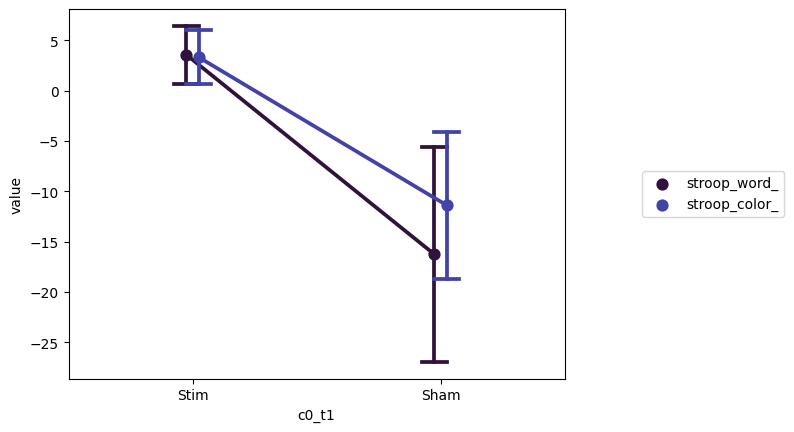

In [9]:
for h in hue:
    a = dh[(dh.c0_t1=='Sham')&(dh.variable==h)].value
    b = dh[(dh.c0_t1=='Stim')&(dh.variable==h)].value
    tval, pval = stats.ttest_ind(a,b,alternative='two-sided')
    print('%s: %.3f (%s)'%(h,pval,convert_pvalue_to_asterisks(pval)))
    if not pval < 0.05:
        dh.drop(dh[dh.variable==h].index, inplace=True)

g = sns.pointplot(
    data=dh,
    x='c0_t1', y='value',
    hue='variable', palette=cm.turbo(np.linspace(0,1,len(hue))),
    errorbar='se', capsize=0.1,
    dodge=True
)

g.legend(bbox_to_anchor=(1.3, 0.5), loc='center', ncol=1)

---

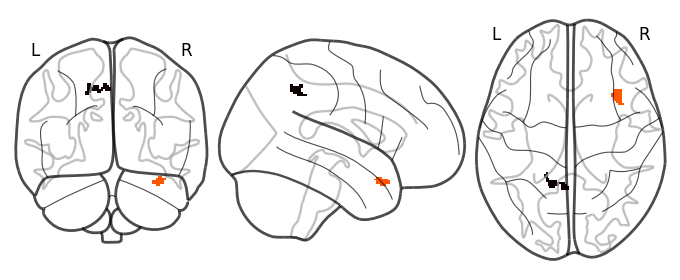

In [10]:
mask = join(dir_mask,'mask.Clust_mask.NN=1.p=0.01.stat_lHP.nii')
labels = ['right_temporal_pole', 'precuneus']
# mask = join(dir_mask,'mask.Precuneus300.nii')
# labels = ['precuneus']
plotting.plot_glass_brain(mask)

In [14]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=mask, memory='/home/sungbeenpark/trash/nilearn_cache', verbose=0
    , labels=labels
)

In [15]:
list_fname = np.concatenate(
    [
        glob(join(dir_corr,'3dTcorr1D.lHP.S??.pre.GlobalSignalRemoved=false.nii')),
        glob(join(dir_corr,'3dTcorr1D.lHP.S??.post.GlobalSignalRemoved=false.nii'))
    ]
)
list_fname.sort()

In [68]:
dp = pd.DataFrame()

for fname in tqdm(list_fname):
    subj = fname.split('/')[-1].split('.')[2]
    nn = subj[1:]
    if not nn in list_subj:
        continue
    phase = 'Post' if '.post.' in fname else ('Pre' if '.pre.' in fname else 'invalid')
    gg = dg.loc[subj,'c0_t1']
    group = 'Sham' if gg==0 else ('Stim' if gg==1 else 'invalid')
    correlations = masker.fit_transform(fname)[0]
    for jj, roi in enumerate(masker.labels):
        new_row = pd.Series(
            {
                'subj':subj, 'phase':phase, 'group':group,
                'roi':roi, 'Pearson_r':correlations[jj]
            }
        )
        dp = pd.concat(
            [dp, new_row.to_frame().T]
            , axis='index'
            , ignore_index=True
        )
dp

100%|██████████| 56/56 [00:01<00:00, 34.21it/s] 


,subj,phase,group,roi,Pearson_r
0,S12,Post,Stim,right_temporal_pole,0.003266
1,S12,Post,Stim,precuneus,0.034387
2,S12,Pre,Stim,right_temporal_pole,0.206359
3,S12,Pre,Stim,precuneus,0.055457
4,S17,Post,Sham,right_temporal_pole,0.02125
...,...,...,...,...,...
75,S47,Pre,Stim,precuneus,0.045202
76,S48,Post,Stim,right_temporal_pole,-0.063307
77,S48,Post,Stim,precuneus,0.111369
78,S48,Pre,Stim,right_temporal_pole,-0.068673


right_temporal_pole, Pre (Sham vs. Stim) : 0.046 (*)
right_temporal_pole, Pre (Sham vs. Stim) : 0.016 (*)
right_temporal_pole, Stim (Pre vs. Post) : 0.0444 (*)
right_temporal_pole, Sham (Pre vs. Post) : 0.0006 (***)
precuneus, Pre (Sham vs. Stim) : 0.074 (ns)
precuneus, Pre (Sham vs. Stim) : 0.001 (**)
precuneus, Stim (Pre vs. Post) : 0.0020 (**)
precuneus, Sham (Pre vs. Post) : 0.0050 (**)


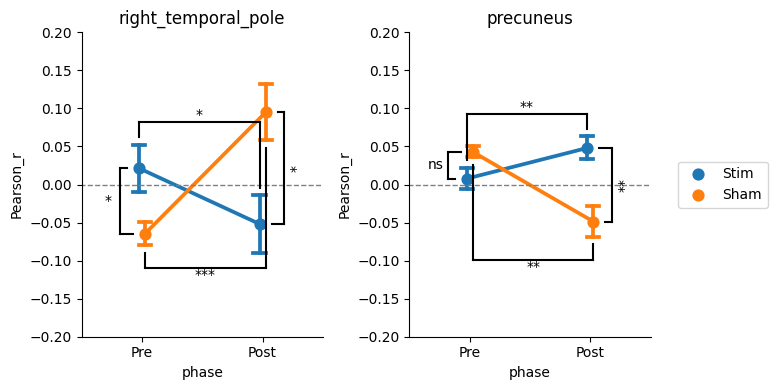

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for ii, roi in enumerate(masker.labels):
    ax = axs[ii]
    g = sns.pointplot(
        data=dp[dp.roi==roi], x='phase', y='Pearson_r', hue='group',
        order=['Pre', 'Post'],
        errorbar='se', capsize=0.1,
        dodge=True,
        ax=ax
    )
    g.set_title(roi)
    g.get_legend().remove()
    g.set_ylim(-0.2,0.2)
    g.set_xlim(-0.5,1.5)
    g.hlines(
        y=0,
        xmin=-1, xmax=2,
        linestyle='--', color='gray', linewidth=1.0
    )
    
    ## In Pre, Stim vs. Sham
    a = dp[(dp.roi==roi)&(dp.group=='Sham')&(dp.phase=='Pre')].Pearson_r
    b = dp[(dp.roi==roi)&(dp.group=='Stim')&(dp.phase=='Pre')].Pearson_r
    tval, pval = stats.ttest_ind(a.astype(float),b.astype(float),alternative='two-sided')
    print('%s, Pre (Sham vs. Stim) : %.3f (%s)'%(roi, pval, convert_pvalue_to_asterisks(pval)))
    dx = 0.025
    g.plot([-0.1+dx,-0.18], [a.mean(),a.mean()], color='black', linestyle='-')
    g.plot([-0.1-dx,-0.18], [b.mean(),b.mean()], color='black', linestyle='-')
    g.plot([-0.18,-0.18], [a.mean(),b.mean()], color='black', linestyle='-')
    g.text(
        -0.28, (a.mean()+b.mean())*0.5, convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=0, size=10
        , color='black'
    )
    
    ## In Post, Stim vs. Sham
    a = dp[(dp.roi==roi)&(dp.group=='Sham')&(dp.phase=='Post')].Pearson_r
    b = dp[(dp.roi==roi)&(dp.group=='Stim')&(dp.phase=='Post')].Pearson_r
    tval, pval = stats.ttest_ind(a.astype(float),b.astype(float),alternative='two-sided')
    print('%s, Pre (Sham vs. Stim) : %.3f (%s)'%(roi, pval, convert_pvalue_to_asterisks(pval)))
    dx = 0.025
    g.plot([1.1+dx,1.18], [a.mean(),a.mean()], color='black', linestyle='-')
    g.plot([1.1-dx,1.18], [b.mean(),b.mean()], color='black', linestyle='-')
    g.plot([1.18,1.18], [a.mean(),b.mean()], color='black', linestyle='-')
    g.text(
        1.28, (a.mean()+b.mean())*0.5, convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=90, size=10
        , color='black'
    )

    ## Paired T-Test
    for group in ['Stim','Sham']:
        a = dp[(dp.roi==roi)&(dp.group==group)&(dp.phase=='Pre')].Pearson_r
        b = dp[(dp.roi==roi)&(dp.group==group)&(dp.phase=='Post')].Pearson_r
        tval, pval = stats.ttest_rel(a,b,alternative='two-sided')
        print('%s, %s (Pre vs. Post) : %.4f (%s)'%(roi, group, pval, convert_pvalue_to_asterisks(pval)))
        if pval < 0.5:
            if group=='Stim':
                dx = -0.025
                y1, y2 = a.mean()+a.sem(), b.mean()+b.sem()
                yt = max(y1,y2)+0.03
                dy = 0.01
                va = 'bottom'
            else:
                dx = 0.025
                y1, y2 = a.mean()-a.sem(), b.mean()-b.sem()
                yt = min(y1,y2)-0.03
                dy = -0.01
                va = 'top'
                
            x1, x2 = 0+dx, 1+dx
            g.plot([x1,x1], [y1+dy,yt], color='black', linestyle='-')
            g.plot([x2,x2], [y2+dy,yt], color='black', linestyle='-')
            g.plot([x1,x2], [yt,yt], color='black', linestyle='-')
            g.text(
                (x1+x2)*0.5, yt, convert_pvalue_to_asterisks(pval)
                , ha='center', va=va, rotation=0, size=10
                , color='black'
            )

g.legend(bbox_to_anchor=(1.3,0.5), loc='center', ncol=1)
            
sns.despine()
fig.tight_layout()

---

y : $\Delta$Performance (post - pre) \
x : $\Delta$Pearson (post - pre) \
hue : stim vs. sham

x

In [131]:
dp.Pearson_r = dp.Pearson_r.astype(float)
dp.set_index('subj', inplace=True)

In [134]:
dp

,phase,group,roi,Pearson_r
subj,,,,
S12,Post,Stim,right_temporal_pole,0.003266
S12,Post,Stim,precuneus,0.034387
S12,Pre,Stim,right_temporal_pole,0.206359
S12,Pre,Stim,precuneus,0.055457
S17,Post,Sham,right_temporal_pole,0.021250
...,...,...,...,...
S47,Pre,Stim,precuneus,0.045202
S48,Post,Stim,right_temporal_pole,-0.063307
S48,Post,Stim,precuneus,0.111369


y

In [114]:
dh.set_index('tms_id', inplace=True)
dh.reset_index(inplace=True)

In [80]:
scaler = StandardScaler()

In [119]:
for var in dh.variable.unique():
    tmp = dh[dh.variable==var]
    
    # standardization
    scale = scaler.fit_transform(np.array(tmp.value).reshape(-1,1))
    
    for ii, row in enumerate(tmp.index):
        dh.loc[row,'value'] = scale[ii,0]

new dataframe

In [124]:
dh.set_index('tms_id', inplace=True)

In [140]:
da = pd.DataFrame()

for nn in list_subj:
    subj = 'S%s'%nn
    gg = dg.loc[subj,'c0_t1']
    group = 'Sham' if gg==0 else ('Stim' if gg==1 else 'invalid')
    for roi in masker.labels:
        x = dp[(dp.roi==roi)&(dp.phase=='Post')].Pearson_r - dp[(dp.roi==roi)&(dp.phase=='Pre')].Pearson_r
        for var in dh.variable.unique():
            y = dh[dh.variable==var].value    
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group,
                    'score_name':var, 'delta_score':y[subj],
                    'roi':roi, 'delta_r':x[subj]
                }
            )
            da = pd.concat(
                [da, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
da.delta_score = da.delta_score.astype(float)
da.delta_r = da.delta_r.astype(float)
da

,subj,group,score_name,delta_score,roi,delta_r
0,S12,Stim,stroop_word_,0.200858,right_temporal_pole,-0.203093
1,S12,Stim,stroop_color_,1.615125,right_temporal_pole,-0.203093
2,S12,Stim,stroop_word_,0.200858,precuneus,-0.021070
3,S12,Stim,stroop_color_,1.615125,precuneus,-0.021070
4,S17,Sham,stroop_word_,0.154684,right_temporal_pole,0.114130
...,...,...,...,...,...,...
75,S47,Stim,stroop_color_,0.224411,precuneus,0.006580
76,S48,Stim,stroop_word_,0.200858,right_temporal_pole,0.005366
77,S48,Stim,stroop_color_,0.161196,right_temporal_pole,0.005366
78,S48,Stim,stroop_word_,0.200858,precuneus,0.073742


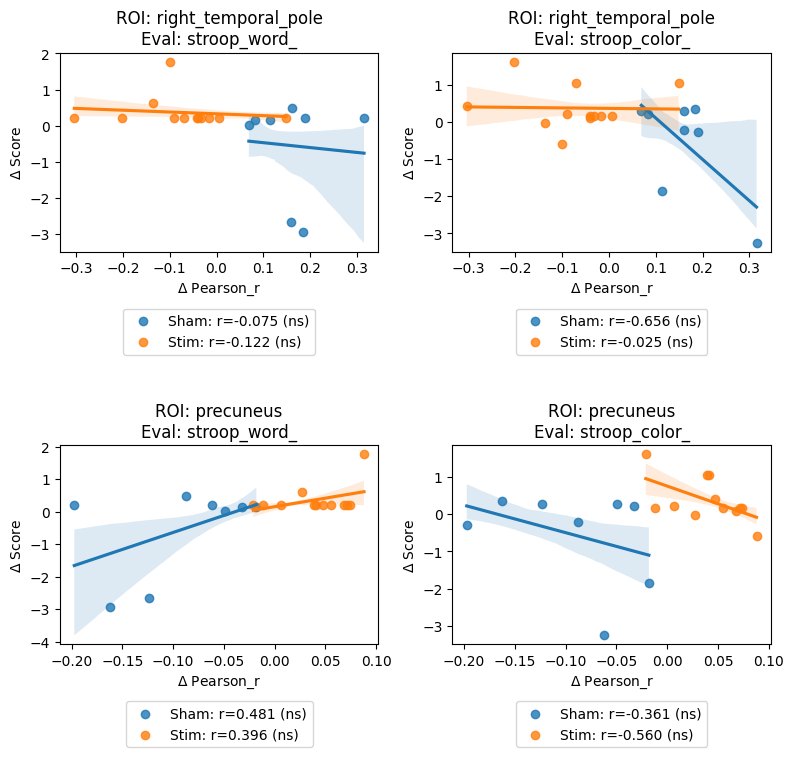

In [141]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

for ii, roi in enumerate(masker.labels):
    for jj, var in enumerate(dh.variable.unique()):
        ax = axs[ii,jj]
        tmp = da[(da.roi==roi)&(da.score_name==var)]
        for group in ['Sham', 'Stim']:
            x = tmp[tmp.group==group].delta_r
            y = tmp[tmp.group==group].delta_score
            r, pval = stats.pearsonr(x,y)
            g = sns.regplot(
                data=tmp[tmp.group==group], x='delta_r', y='delta_score',
                ci=68,
                ax=ax, label='%s: r=%.3f (%s)'%(group,r,convert_pvalue_to_asterisks(pval))
            )
            g.set_title('ROI: %s\nEval: %s'%(roi,var))
            g.legend(bbox_to_anchor=(0.5,-0.4), loc='center', ncol=1)
            g.set_ylabel(r'$\Delta$ Score')
            g.set_xlabel(r'$\Delta$ Pearson_r')
    
fig.tight_layout()

/home/sungbeenpark/anaconda3/envs/SMC/lib/python3.9/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/sungbeenpark/anaconda3/envs/SMC/lib/python3.9/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/sungbeenpark/anaconda3/envs/SMC/lib/python3.9/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/sungbeenpark/anaconda3/envs/SMC/lib/python3.9/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will rai

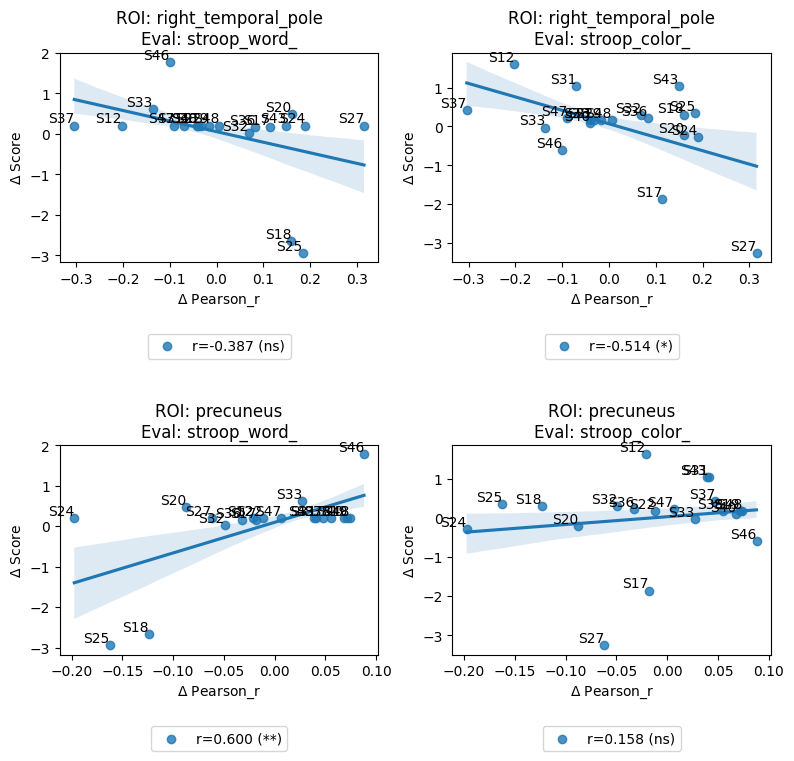

In [142]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

for ii, roi in enumerate(masker.labels):
    for jj, var in enumerate(dh.variable.unique()):
        ax = axs[ii,jj]
        tmp = da[(da.roi==roi)&(da.score_name==var)]
        
        x = tmp.delta_r
        y = tmp.delta_score
        r, pval = stats.pearsonr(x,y)
        g = sns.regplot(
            data=tmp, x='delta_r', y='delta_score',
            ci=68,
            ax=ax, label='r=%.3f (%s)'%(r,convert_pvalue_to_asterisks(pval))
        )
        g.set_title('ROI: %s\nEval: %s'%(roi,var))
        g.legend(bbox_to_anchor=(0.5,-0.4), loc='center', ncol=1)
        g.set_ylabel(r'$\Delta$ Score')
        g.set_xlabel(r'$\Delta$ Pearson_r')
        for nn in list_subj:
            subj = 'S%s'%nn
            g.text(
                tmp[tmp.subj==subj].delta_r, tmp[tmp.subj==subj].delta_score,
                subj,
                ha='right', va='bottom', rotation=0, size=10,
                color='black'
            )
    
fig.tight_layout()